# INF552 Homework1:  Vertebral Column Data Set 

Student Name : Hsin-Yu, Chang (1160173733)

### (a)  Download the Vertebral Column Data Set 

In [1]:
import urllib.request
import zipfile
import pandas

In [2]:
#1.(a) download from URL

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip"
zipname = "vertebral_column_data.zip"
#download a zip file from Web(URL)
urllib.request.urlretrieve(url, zipname)
 
#unzip & open data & use pandas to read file into dataframe
VerCol = zipfile.ZipFile(zipname).open("column_2C.dat")
VerColdf = pandas.read_table(VerCol, header=None, sep = '\s+',
                             names = ["pelincidence", "peltilt","lorangle", "slope", "pelradius", "grade", "labels"] )


In [3]:
VerColdf.head(5) # first 5 heading data

,pelincidence,peltilt,lorangle,slope,pelradius,grade,labels
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB


In [4]:
VerColdf.tail(5) # last 5 tailing data

,pelincidence,peltilt,lorangle,slope,pelradius,grade,labels
305,47.90,13.62,36.00,34.29,117.45,-4.25,NO
306,53.94,20.72,29.22,33.22,114.37,-0.42,NO
307,61.45,22.69,46.17,38.75,125.67,-2.71,NO
308,45.25,8.69,41.58,36.56,118.55,0.21,NO
309,33.84,5.07,36.64,28.77,123.95,-0.20,NO


The Vertebral Column data set contains 310 patients with their six biomechanical attributes: pelvic incidence (pelincidence), pelvic tilt (peltilt), lumbar lordosis angle (lorangle), sacral slope (slope), pelvic radius (pelradius), grade of spondylolisthesis (grade), and also a binary class: Normal (NO) and Abnormal (AB). 

### (b) Pre-Processing and Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

##### i. Scatterplots of the independent variables

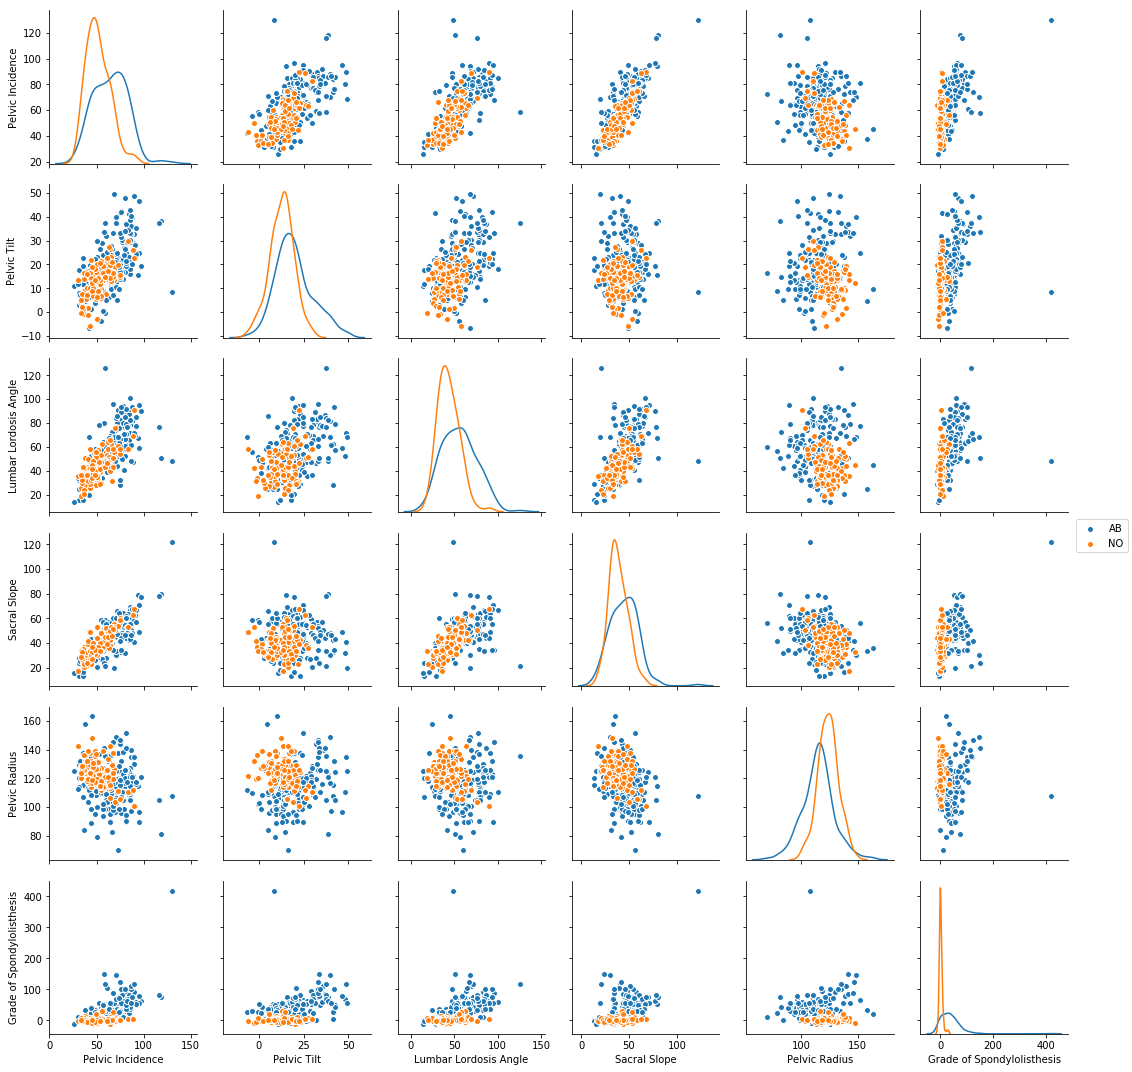

In [6]:
#1.(b)i. ScatterPlots of the independent variables

plot = sns.pairplot(VerColdf, hue="labels", diag_kind="kde")
colname = ["Pelvic Incidence", "Pelvic Tilt", 
           "Lumbar Lordosis Angle", "Sacral Slope", 
           "Pelvic Radius", "Grade of Spondylolisthesis"]

#change axis label 
for i in range(6):
        plot.axes[5,i].xaxis.set_label_text(colname[i])
for i in range(6):
        plot.axes[i,0].yaxis.set_label_text(colname[i])
plot._legend.set_title('')
        

plt.show()

##### (ii) Boxplots for each independent variables

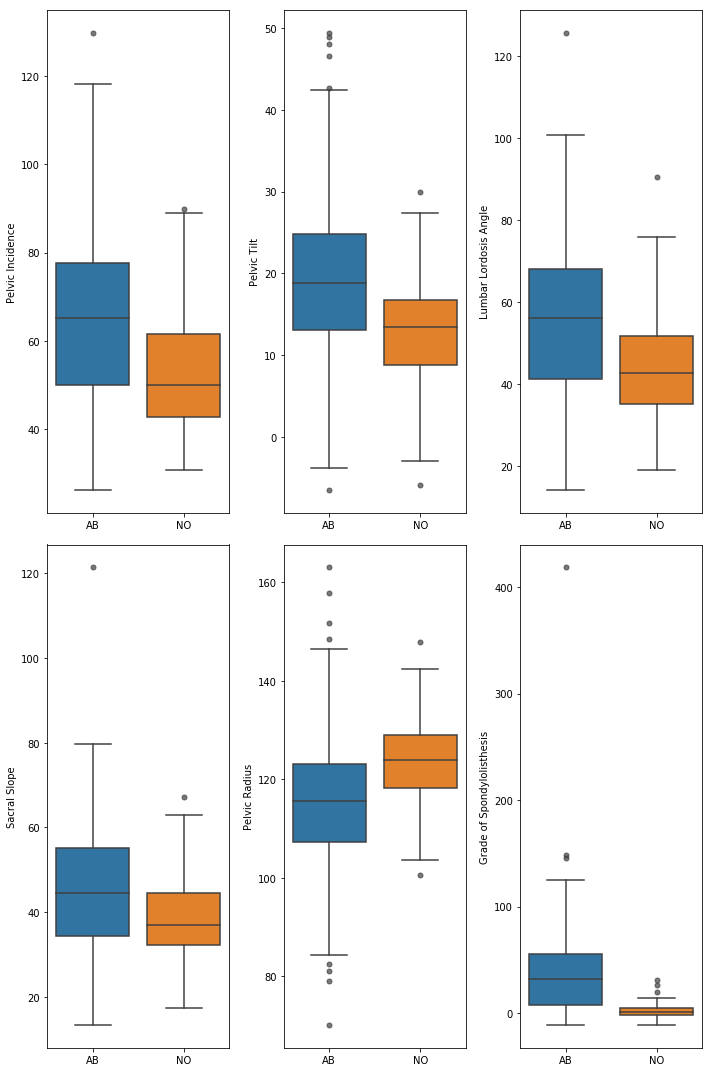

In [7]:
#1.(b)ii. Boxplots for each independent variables

colname = ["Pelvic Incidence", "Pelvic Tilt", 
           "Lumbar Lordosis Angle", "Sacral Slope", 
           "Pelvic Radius", "Grade of Spondylolisthesis"]


plt.figure(figsize=(10,15))
flierprops = dict(marker='o', markersize=5, alpha=0.7) #set outliers'properties

for i, col in enumerate(VerColdf.columns[:6], start=1):
    plt.subplot(2,3,i)
    sns.boxplot(x="labels", y=col,
                data=VerColdf,flierprops=flierprops).xaxis.label.set_visible(False)
    plt.ylabel(colname[i-1])
plt.tight_layout()


Among six biomechanical attributes, only variable Pelvic Radius has a lower median value under abnormal patients, other five attributes, by contrast, have higher meadian value under abnormal patients. Apart from this, distributions of Grade of Spondylolisthesis under two class, AB and NO, have an obvious difference in interquartile range, normal patients hold a lower variabilty, many of them concentrate roughly at 0. 

##### iii. Seperate dataset into training and testing set

In [8]:
#1.(b)iii.

VerColdftrain = pandas.concat([VerColdf[VerColdf.labels=='NO'].iloc[0:70,:],
                               VerColdf[VerColdf.labels=='AB'].iloc[0:140,:]],
                               ignore_index=True)


In [43]:
VerColdftrain.shape

(210, 7)

In [9]:
VerColdftest = pandas.concat([VerColdf[VerColdf.labels=='NO'].iloc[70:,:],
                               VerColdf[VerColdf.labels=='AB'].iloc[140:,:]],
                               ignore_index=True)

In [44]:
VerColdftest.shape

(100, 7)

### (c) Classification using KNN with Euclidean Metric

##### i. Euclidean Metric function

$$X = (x_1, x_2, ..., x_n)$$
$$Y = (y_1, y_2, ..., y_n)$$
$$Euclidean (X, Y)=\sqrt{\sum_{i=1}^n {(x_i-y_i)^2}}$$

In [10]:
#1.(c)i.

#Euclidean function
import numpy as np
import math

def EuclideanDistance(point1, point2, *unused):
    p1 = np.array(point1)
    p2 = np.array(point2)
    distance = math.sqrt(sum((p1-p2)**2))
    return distance

##### k-Nerarest Neightbors (KNN) function
#### Function introduction:
1. Find k neighbors (data points) of every testing data point in training set with selected distance function.
<br>(Euclidean metric, Minkowski Distance, Chebyshev Distance and Mahalanobis Distance can be used.)
2. By polling, we make class decision based on the k neighnbors.  
3. For evaluating the knn classifier, compare majority polling decision and the actual class of the test set.
<br>(this function returns error rate and confusion matrix in a dictionary data type)

#### parameters:
trainingx - independent variable of training set. 
<br>trainingy - dependent variable of training set. 
<br>testingx - independent variable of testing set. 
<br>testingy - dependent variable of testing set. 
<br>k - number of neighbors for decision making.
<br>weighted - if True, we use Inverse Distance Weighting; if False, just do majority polling.
<br>distanceFUN - choose from EuclideanDistance, MinkowskiDistance, ChebyshevDistance and MahalanobisDistance.
<br>*args - other parameters might be used for different distance function, e.g. p for MinkowskiDistance.

In [11]:
from sklearn.metrics import confusion_matrix
    
def knnclassifier(trainingx, trainingy, testingx, testingy, k, weighted, distanceFUN, *args):    
    
    #find neighbor k        
    trainingx = pandas.DataFrame(trainingx)
    testingx = pandas.DataFrame(testingx)
    rt,colt = trainingx.shape
    r,col = testingx.shape
    poll = []
      
    for i in range(r): #for every test data x
        distance = []
        for j in range(rt): #distance between one point and everypoint in training set
            if distanceFUN.__name__ != "MahalanobisDistance":
                distance.append(distanceFUN(testingx.iloc[i], trainingx.iloc[j], *args)) #number of noname arguments
            else:
                distance.append(distanceFUN(testingx.iloc[i], trainingx.iloc[j], trainingx))

        distance = np.array(distance)
        temp = trainingy.values #from series to ndarray
        
        #get smallest k distance, not ordered, just get them only
        #argpartition return ndarray
        if weighted != True:
            temp = temp[np.argpartition(distance, k)[:k]].tolist()  
            temp = dict((c,temp.count(c)/len(temp)) for c in set(temp)) #count only for list
        else:
            temp = temp[np.argpartition(distance, k)[:k]]  
            distemp = distance[np.argpartition(distance, k)[:k]] 
            distemp = (1/distemp)/sum(1/distemp) #Inverse distance weighting
            temp = dict((c, sum(distemp[temp==c])) for c in set(temp)) 

        poll.append(str(max(temp, key=temp.get))) #find class(key) with max value(majority)
    
    #prediction summary
    errorRate = (poll!=testingy).sum() / len(testingy)
    #confusion matrix
    actu = pandas.Series(testingy, name='Actual')
    pred = pandas.Series(poll, name='Predicted')
    confusionM = confusion_matrix(pred, actu, labels=["AB", "NO"])

    return {'errorrate':errorRate,
            'confusion':confusionM}


##### Model Evaluation function
Calculate sensitivity (true positive rate), specificity (true negative rate), precision, accuracy, and F-score from a confusion matrix. 

In [12]:
def ModelEvaluation(confusionM):
    TP = round((confusionM[0,0])/(confusionM[0,0]+confusionM[1,0]), 3) #sensitivity
    TN = round((confusionM[1,1])/(confusionM[0,1]+confusionM[1,1]), 3) #specificity
    precision = round((confusionM[0,0])/(confusionM[0,0]+confusionM[0,1]), 3) 
    accuracy = round((confusionM[0,0]+confusionM[1,1])/sum(sum(confusionM)), 3) 
    F_value = round((2*confusionM[0,0])/(2*confusionM[0,0]+confusionM[1,0]+confusionM[0,1]), 3)
    print("\nWhen k = ", k, ":",
          "\nSensitivity(TPR) = ", TP,
          "\nSpecificity(TNR) = ", TN,
          "\nPrecision = ", precision,
          "\nAccuracy = ", accuracy,
          "\nF-value = ", F_value) 

##### ii. Plot Train and Test errors in terms of k

In [13]:
#1.(c)ii.
    
#train
trainingx = VerColdftrain.iloc[:,:-1]
trainingy = VerColdftrain.iloc[:,-1]

trainerror = []
for k in range(208, 0, -3):
    trainerror.append(float(knnclassifier(trainingx, trainingy, trainingx, trainingy, k, False, EuclideanDistance)['errorrate'])) 


In [14]:
#test
testingx = VerColdftest.iloc[:,:-1]
testingy = VerColdftest.iloc[:,-1]

testerror = []
for k in range(208, 0, -3):
    testerror.append(float(knnclassifier(trainingx, trainingy, testingx, testingy, k, False, EuclideanDistance)['errorrate']))    
    

In [52]:
#combine trainerror & testerror to a dataframe    
errordf = pandas.DataFrame(
    {'k': range(208, 0, -3),
     'trainerror': trainerror,
     'testerror': testerror
    })

int(errordf[errordf.testerror == min(errordf.testerror)].k)

4

when k = 4, knn classifier generates the best error rate.

In [50]:
#set k = 4, which generate the smallest testing error rate
k=4
knn = knnclassifier(trainingx, trainingy, testingx, testingy, k, False, EuclideanDistance)
knn['confusion']

array([[70,  8],
       [ 0, 22]])

this confusion matrix is formed from prediction X actual outcome, with class order AB and NO.
<br>e.g. the value 70 in the matrix means prediction = AB & actual = AB; the value 8 means prediction = AB & actual = NO 

In [51]:
ModelEvaluation(knn['confusion'])


When k =  4 : 
Sensitivity(TPR) =  1.0 
Specificity(TNR) =  0.733 
Precision =  0.897 
Accuracy =  0.92 
F-value =  0.946


From Accuracy = 0.92, it shows error rate is 0.08 when k = 4.

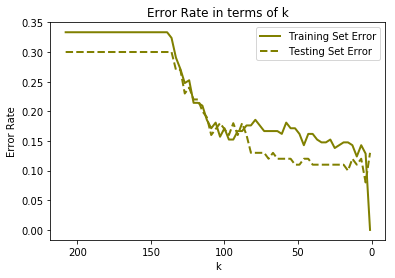

In [38]:
import matplotlib.pyplot as plt
plt.plot( 'k', 'trainerror', data = errordf, marker='', color='olive', linewidth=2, label="Training Set Error")
plt.plot( 'k', 'testerror', data = errordf, marker='', color='olive', linewidth=2, linestyle='dashed', label="Testing Set Error")
plt.legend()
plt.title('Error Rate in terms of k')
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.gca().invert_xaxis()

##### iii. Plot  Best Test Error Rate against the size of training set

In [39]:
#1.(c)iii. the subset of training set with the best test rate 

besterr = []

for N in range(10, 211, 10):
    #size N of training dataset
    trainsub = pandas.concat([VerColdftrain[VerColdftrain.labels=='NO'].iloc[0:math.floor(N/3),:],
                              VerColdftrain[VerColdftrain.labels=='AB'].iloc[0:(N-math.floor(N/3)),:]],
                              ignore_index=True)

    trainsubx = trainsub.iloc[:,:-1]
    trainsuby = trainsub.iloc[:,-1]
    errormin = 1
    for k in range(1, N+1, 5):
        err = float(knnclassifier(trainsubx, trainsuby, testingx, testingy, k, False, EuclideanDistance)['errorrate'])
        if  err < errormin:
            errormin = err
            optimal = k
        #errormin = min(err,errormin)
    besterr.append({'N':N, 'Optimal k':k, 'errormin':errormin}) 


Text(0,0.5,'Error Rate')

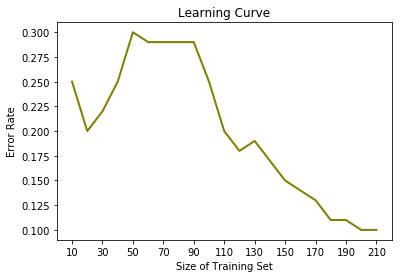

In [40]:
#draw Learing Curve base on size of training set
besterr = pandas.DataFrame(besterr)
plt.plot( 'N', 'errormin', data = besterr, marker='', color='olive', linewidth=2 )
plt.xticks(np.arange(10, 211, step=20))
plt.title('Learning Curve')
plt.xlabel('Size of Training Set')
plt.ylabel('Error Rate')

This learning curve shows that as the size of training set gets larger, knn classifier generates lower error rate on the whole.

### (d) Classification using KNN with other Metrics

##### i. Minkowski Distance

$$X = (x_1, x_2, ..., x_n)$$
$$Y = (y_1, y_2, ..., y_n)$$
$$Minkowski (X, Y)=(\sum_{i=1}^n {\mid{x_i-y_i}\mid^{p}})^\frac{1}{p}$$

In [21]:
#1.(d)i.

#A. knn with Minkowski Distance
def MinkowskiDistance(point1, point2, p):
    p1 = np.array(point1)
    p2 = np.array(point2)
    distance = pow((sum(abs(p1-p2)**p)), (1/p))
    return distance

A. Manhattan Distance, when p = 1

In [22]:
#knn with Minkowski Distance when p = 1

Manherror=[]
for k in range(1, 200, 5):
    Manherror.append({'k':k, 'error':knnclassifier(trainingx, trainingy, testingx, testingy, k, False, MinkowskiDistance, 1)['errorrate']})

Manherror = pandas.DataFrame(Manherror)    
Manhk = np.array(Manherror[Manherror.error == min(Manherror.error)].k)[0] #find k with the best error rate

#Model Evaluation 
k=Manhk
knn = knnclassifier(trainingx, trainingy, testingx, testingy, k, False, MinkowskiDistance, 1)
ModelEvaluation(knn['confusion'])



When k =  11 : 
Sensitivity(TPR) =  0.986 
Specificity(TNR) =  0.667 
Precision =  0.873 
Accuracy =  0.89 
F-value =  0.926


<br>B. Minkowski Distance with different log10(p) 

In [54]:
#B.knn with Minkowski Distance, setting different log10(p) 

#make log array
arr = np.array(np.arange(1, 0, -0.1))
arr = [math.pow(10, i) for i in arr]
arr.reverse()

Logerror=[]
for log in arr:
    Logerror.append({'log':log, 'error':knnclassifier(trainingx, trainingy, testingx, testingy, Manhk, False, MinkowskiDistance, round(log,2))['errorrate']})

Logerror = pandas.DataFrame(Logerror) 
log = Logerror[Logerror.error == min(Logerror.error)].log # the best log10(p)
log


0     1.258925
1     1.584893
7     6.309573
8     7.943282
9    10.000000
Name: log, dtype: float64

In [57]:
[round(math.log10(x),2) for x in log.values]

[0.1, 0.2, 0.8, 0.9, 1.0]

These log10(p) generate the best error rate with optimal k = 11 from Manhattan Distance.

In [59]:
#Model Evaluation with best log10(p), use log10(p)=0.1 as represent
k = Manhk
knn = knnclassifier(trainingx, trainingy, testingx, testingy, k, False, MinkowskiDistance, arr[0])
ModelEvaluation(knn['confusion'])



When k =  11 : 
Sensitivity(TPR) =  0.986 
Specificity(TNR) =  0.667 
Precision =  0.873 
Accuracy =  0.89 
F-value =  0.926


<br>C. Chebyshev Distance 

$$X = (x_1, x_2, ..., x_n)$$
$$Y = (y_1, y_2, ..., y_n)$$
$$Chebyshev (X, Y)=max_{i}(\mid{x_i-y_i}\mid)$$

In [25]:
#C.knn with Chebyshev Distance

def ChebyshevDistance(point1, point2, *unused):
    p1 = np.array(point1)
    p2 = np.array(point2)
    distance = max(abs(p1-p2))
    return distance

In [26]:
Cheberror=[]
for k in range(1, 200, 5):
    Cheberror.append({'k':k, 'error':knnclassifier(trainingx, trainingy, testingx, testingy, k, False, ChebyshevDistance)['errorrate']})

Cheberror = pandas.DataFrame(Cheberror)
Chebk = np.array(Cheberror[Cheberror.error == min(Cheberror.error)].k)[0]

#Model Evaluation 
k=Chebk
knn = knnclassifier(trainingx, trainingy, testingx, testingy, k, False, ChebyshevDistance)
ModelEvaluation(knn['confusion'])


When k =  16 : 
Sensitivity(TPR) =  1.0 
Specificity(TNR) =  0.633 
Precision =  0.864 
Accuracy =  0.89 
F-value =  0.927


##### ii. Mahalanobis Distance

$$X = (x_1, x_2, ..., x_n)$$
$$Y = (y_1, y_2, ..., y_n)$$
$$Mahalanobis (X, Y)=\sqrt{(X-Y)^{T}S^{-1}(X-Y)}$$

<br> With the knnclassifier function defining above, the covariance matrix of the independent variables from training set represents S in calculating Mahalanobis distance. Also, if the covariance matrix is singular, we use pseudoinverse instead. 

In [27]:
#1.(d)ii. knn with Mahalanobis Distance

def MahalanobisDistance(point1, point2, dfx):
    p1 = np.array(point1)
    p2 = np.array(point2)
    Cov = dfx.cov()
    try:
        invCov = np.linalg.inv(Cov)
    except:
        invCov = np.linalg.pinv(Cov) #for singular matrix
    distance = np.sqrt(np.dot(np.dot((p1-p2),invCov), (p1-p2).T))
    return distance

In [28]:
Mahaerror=[]
for k in range(1, 200, 5):
    Mahaerror.append({'k':k, 'error':knnclassifier(trainingx, trainingy, testingx, testingy, k, False, MahalanobisDistance)['errorrate']})

Mahaerror = pandas.DataFrame(Mahaerror) 
Mahak = np.array(Mahaerror[Mahaerror.error == min(Mahaerror.error)].k)[0]

#Model Evaluation 
k=Mahak
knn = knnclassifier(trainingx, trainingy, testingx, testingy, k, False, MahalanobisDistance)
ModelEvaluation(knn['confusion'])



When k =  1 : 
Sensitivity(TPR) =  0.929 
Specificity(TNR) =  0.6 
Precision =  0.844 
Accuracy =  0.83 
F-value =  0.884


### (e) KNN classification with Weighted Voting

I use "Inverse Distance Weighting" to vote for the decision, greater influence for closer neighbor.
<br>Weight for a neighbor is calculated by following function:

$$w_i = \frac{\frac{1}{d_i}}{\sum_i^k\frac{1}{d_i}}$$

- KNN weighted voting with Euclidean

In [29]:
# weight voting with Euclidean

wEucerror=[]
for k in range(1, 200, 5):
    wEucerror.append({'k':k, 'error':knnclassifier(trainingx, trainingy, testingx, testingy, k, True, EuclideanDistance)['errorrate']})

wEucerror = pandas.DataFrame(wEucerror)    
wEuck = int(wEucerror[wEucerror.error == min(wEucerror.error)].k)

#Model Evaluation 
k = wEuck
knn = knnclassifier(trainingx, trainingy, testingx, testingy, k, True, EuclideanDistance)
ModelEvaluation(knn['confusion'])



When k =  6 : 
Sensitivity(TPR) =  1.0 
Specificity(TNR) =  0.667 
Precision =  0.875 
Accuracy =  0.9 
F-value =  0.933


- KNN weighted voting with Manhattan

In [30]:
# weight voting with Manhattan

wManherror=[]
for k in range(1, 200, 5):
    wManherror.append({'k':k, 'error':knnclassifier(trainingx, trainingy, testingx, testingy, k, True, MinkowskiDistance, 1)['errorrate']})

wManherror = pandas.DataFrame(wManherror)    
wManhk = int(wManherror[wManherror.error == min(wManherror.error)].k)

#Model Evaluation 
k = wManhk
knn = knnclassifier(trainingx, trainingy, testingx, testingy, k, True, MinkowskiDistance, 1)
ModelEvaluation(knn['confusion'])



When k =  26 : 
Sensitivity(TPR) =  0.986 
Specificity(TNR) =  0.7 
Precision =  0.885 
Accuracy =  0.9 
F-value =  0.932


- KNN weighted voting with Chebychev

In [37]:
# weight voting with Chebychev

wCheberror=[]
for k in range(1, 200, 5):
    wCheberror.append({'k':k, 'error':knnclassifier(trainingx, trainingy, testingx, testingy, k, True, ChebyshevDistance)['errorrate']})

wCheberror = pandas.DataFrame(wCheberror)    
wChebk = np.array(wCheberror[wCheberror.error == min(wCheberror.error)].k)[0]

#Model Evaluation 
k = wChebk
knn = knnclassifier(trainingx, trainingy, testingx, testingy, k, True, ChebyshevDistance)
ModelEvaluation(knn['confusion'])



When k =  16 : 
Sensitivity(TPR) =  1.0 
Specificity(TNR) =  0.633 
Precision =  0.864 
Accuracy =  0.89 
F-value =  0.927


### (f) Lowest Error Rate acheived in the exercise

Based on error rate, the lowest error rate is 0.08, with the knn classifier using Euclidean distance, when choosing 4 closest neighbors as majority decision. 

In [62]:
k=4
knn = knnclassifier(trainingx, trainingy, testingx, testingy, k, False, EuclideanDistance)
ModelEvaluation(knn['confusion'])


When k =  4 : 
Sensitivity(TPR) =  1.0 
Specificity(TNR) =  0.733 
Precision =  0.897 
Accuracy =  0.92 
F-value =  0.946
